## 1. Import dataset & data preprocess

See details in utils/data_preprocess.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Example input images:


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


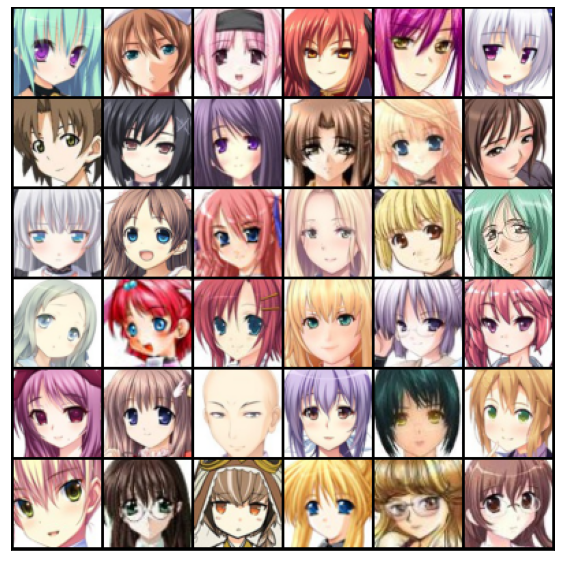

In [ ]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/data_preprocess.ipynb

## 2. Load DCGAN base architecture


In [ ]:
!pip install torchsummary
import torch.nn as nn
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Inputs for the run:
# Number of workers for dataloader
workers = 2
batch_size = 128
image_size = 64
nc = 3    # Number of channels in the training images. For color images this is 3
latent_size = 128  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
epochs = 50
lr = 0.0002
betas = (0.5, 0.999)
ngpu = 1  # Number of GPUs available. Use 0 for CPU mode.
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # in: latent_size x 1 x 1
            #512 = ngf * 8
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
generator = Generator()
discriminator = Discriminator()

torch.Size([128, 3, 64, 64])


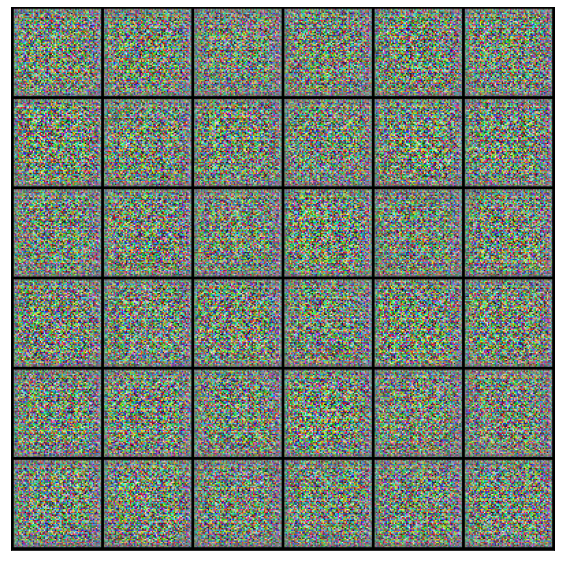

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [ ]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of generator:' + color.END)

print(summary(generator,(latent_size,1,1)))

Architecture of generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
            

In [ ]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of discriminator:' + color.END)
print(summary(discriminator,(3,64,64)))

Architecture of discriminator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
        

## Train DCGAN


In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.autograd import Variable

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
sample_dir = 'generated_dcgan/images'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving 0000.png


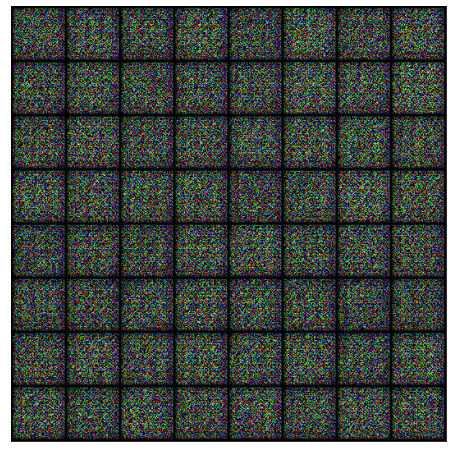

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            # Train discriminator
            # Clear discriminator gradients
            optimizer_D.zero_grad()

            # Pass real images through discriminator
            real_preds = discriminator(real_images)
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            fake_preds = discriminator(fake_images)

            real_targets = torch.ones(real_images.size(0), 1, device=device)
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)

            real_loss = F.binary_cross_entropy(real_preds, real_targets)
            real_score = torch.mean(real_preds).item()
            fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
            fake_score = torch.mean(fake_preds).item()

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()

            optimizer_D.step()
            loss_d = loss_d.item()


            # Clear generator gradients
            optimizer_G.zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            
            # Try to fool the discriminator
            preds = discriminator(fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = F.binary_cross_entropy(preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer_G.step()

            loss_g = loss_g.item()
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 5.8765, loss_d: 0.6030, real_score: 0.6481, fake_score: 0.0156
Saving 0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 6.2625, loss_d: 0.8079, real_score: 0.8888, fake_score: 0.4578
Saving 0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 7.2864, loss_d: 0.7129, real_score: 0.9516, fake_score: 0.4115
Saving 0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 5.7417, loss_d: 1.2348, real_score: 0.4157, fake_score: 0.0004
Saving 0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 5.1885, loss_d: 0.1462, real_score: 0.9885, fake_score: 0.1128
Saving 0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 7.4187, loss_d: 0.2425, real_score: 0.9452, fake_score: 0.1543
Saving 0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 5.4231, loss_d: 0.1878, real_score: 0.9608, fake_score: 0.1176
Saving 0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 6.2455, loss_d: 0.1875, real_score: 0.8673, fake_score: 0.0162
Saving 0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 2.1533, loss_d: 0.4720, real_score: 0.7286, fake_score: 0.0395
Saving 0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 4.8332, loss_d: 0.2998, real_score: 0.7798, fake_score: 0.0031
Saving 0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 4.7674, loss_d: 0.2363, real_score: 0.9394, fake_score: 0.1449
Saving 0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 5.0957, loss_d: 0.0852, real_score: 0.9457, fake_score: 0.0189
Saving 0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 4.7094, loss_d: 0.1399, real_score: 0.9651, fake_score: 0.0889
Saving 0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 4.8642, loss_d: 0.1971, real_score: 0.9428, fake_score: 0.1135
Saving 0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.2417, loss_d: 0.0347, real_score: 0.9920, fake_score: 0.0250
Saving 0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 5.2497, loss_d: 0.1482, real_score: 0.9525, fake_score: 0.0856
Saving 0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 6.2077, loss_d: 0.2523, real_score: 0.9964, fake_score: 0.1938
Saving 0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 3.9993, loss_d: 0.2840, real_score: 0.8918, fake_score: 0.1173
Saving 0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 5.6066, loss_d: 0.5549, real_score: 0.9970, fake_score: 0.3288
Saving 0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 3.6828, loss_d: 0.0899, real_score: 0.9364, fake_score: 0.0200
Saving 0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.4776, loss_d: 0.1837, real_score: 0.9024, fake_score: 0.0486
Saving 0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.2563, loss_d: 0.1385, real_score: 0.9534, fake_score: 0.0748
Saving 0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 6.3283, loss_d: 0.1509, real_score: 0.9863, fake_score: 0.1165
Saving 0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.2995, loss_d: 0.0753, real_score: 0.9638, fake_score: 0.0348
Saving 0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 5.1565, loss_d: 0.1315, real_score: 0.9634, fake_score: 0.0806
Saving 0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 3.9315, loss_d: 0.4234, real_score: 0.8063, fake_score: 0.1175
Saving 0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.7965, loss_d: 0.0584, real_score: 0.9671, fake_score: 0.0233
Saving 0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 5.5582, loss_d: 0.0906, real_score: 0.9811, fake_score: 0.0653
Saving 0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 2.8995, loss_d: 0.3086, real_score: 0.8020, fake_score: 0.0341
Saving 0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 3.5072, loss_d: 0.1761, real_score: 0.8869, fake_score: 0.0389
Saving 0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.5395, loss_d: 0.0680, real_score: 0.9780, fake_score: 0.0422
Saving 0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 4.9008, loss_d: 0.0542, real_score: 0.9847, fake_score: 0.0351
Saving 0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.3582, loss_d: 0.0644, real_score: 0.9762, fake_score: 0.0370
Saving 0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 4.9263, loss_d: 0.3272, real_score: 0.9967, fake_score: 0.2365
Saving 0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.3593, loss_d: 0.2697, real_score: 0.9303, fake_score: 0.1537
Saving 0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 3.0603, loss_d: 0.3969, real_score: 0.8452, fake_score: 0.1458
Saving 0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 4.2501, loss_d: 0.1620, real_score: 0.9513, fake_score: 0.0930
Saving 0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 5.7403, loss_d: 0.0371, real_score: 0.9717, fake_score: 0.0070
Saving 0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 4.6417, loss_d: 0.0532, real_score: 0.9636, fake_score: 0.0137
Saving 0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 5.0425, loss_d: 0.0434, real_score: 0.9751, fake_score: 0.0167
Saving 0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 2.5092, loss_d: 0.1470, real_score: 0.9084, fake_score: 0.0348
Saving 0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.8571, loss_d: 0.0672, real_score: 0.9597, fake_score: 0.0220
Saving 0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 5.2772, loss_d: 0.0364, real_score: 0.9779, fake_score: 0.0128
Saving 0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 5.0056, loss_d: 0.0298, real_score: 0.9928, fake_score: 0.0219
Saving 0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 6.0255, loss_d: 0.0289, real_score: 0.9918, fake_score: 0.0193
Saving 0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.3844, loss_d: 0.1698, real_score: 0.9149, fake_score: 0.0607
Saving 0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 5.5456, loss_d: 0.0821, real_score: 0.9966, fake_score: 0.0687
Saving 0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 5.0223, loss_d: 0.1251, real_score: 0.9553, fake_score: 0.0670
Saving 0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.7830, loss_d: 0.0709, real_score: 0.9543, fake_score: 0.0204
Saving 0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 5.7626, loss_d: 0.0726, real_score: 0.9570, fake_score: 0.0213
Saving 0050.png


In [ ]:
losses_g_dcgan, losses_d_dcgan, real_scores_dcgan, fake_scores_dcgan = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

## Output visualization & evaluation


In [ ]:
output_dir = '/content/generated_dcgan/images'

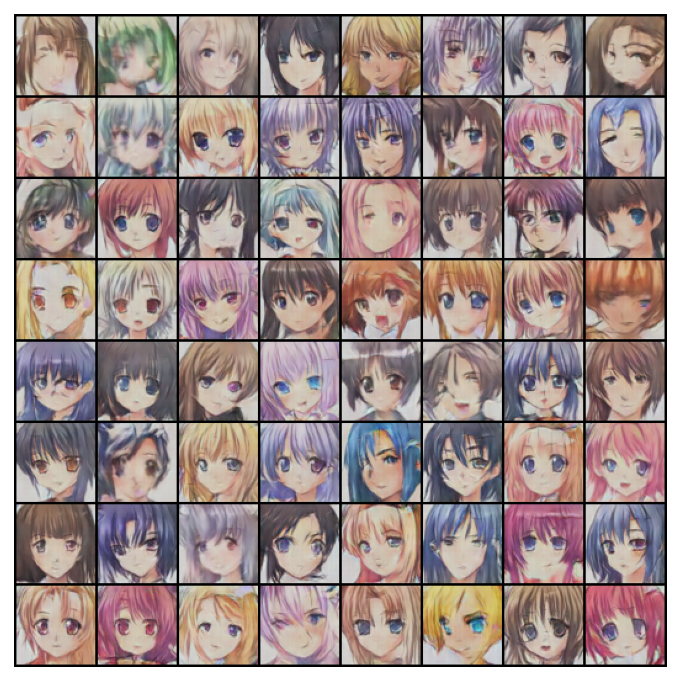

In [ ]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/visualize_outputs.ipynb

In [ ]:
import matplotlib.animation as anim
from IPython.display import HTML
import os
#libraries
import matplotlib.pyplot as plt
import torch
from numpy import array
from scipy import misc
import os
import numpy as np
%matplotlib inline
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

imgs = sorted([
    f for f in os.listdir(output_dir) 
    if f.endswith(".png")], key=lambda x: int(x[:-4]))

ims = []

fig = plt.figure(figsize=(6, 6))

for f in imgs:
    ims.append([plt.imshow(plt.imread(os.path.join(output_dir, f)), animated=True)])

plt.axis("off")

ani = anim.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)

HTML(ani.to_jshtml())

In [ ]:
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

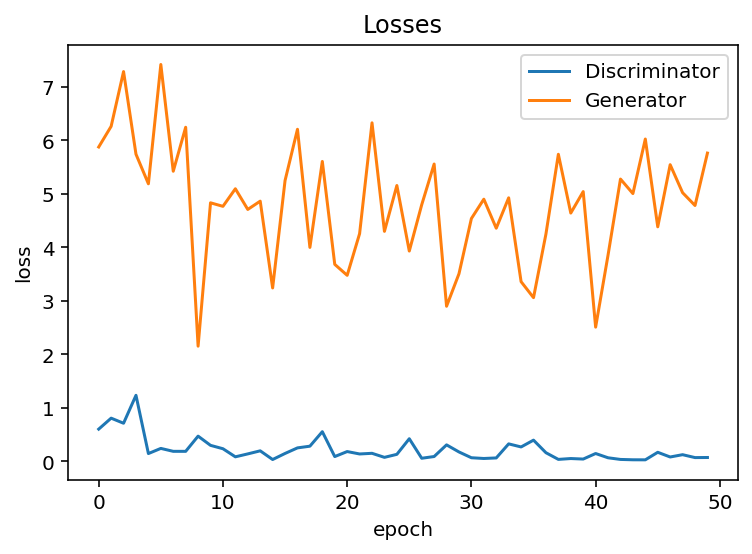

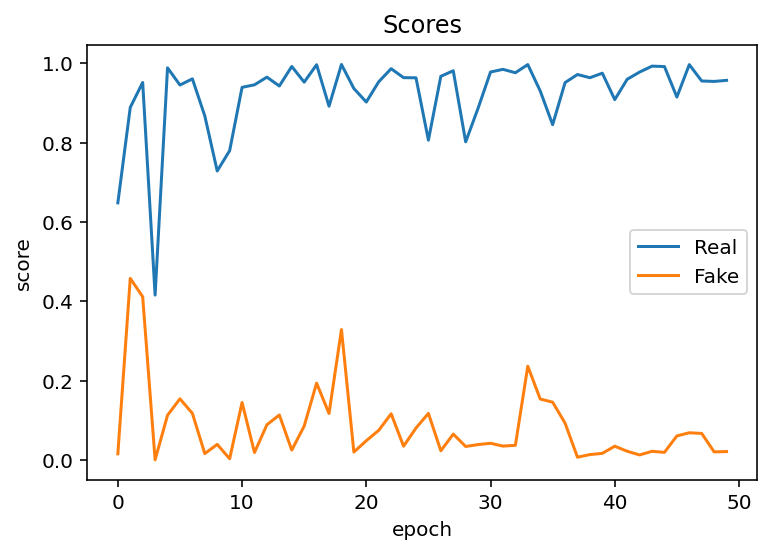

In [ ]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/eval.ipynb

In [8]:
path = '/content/generated_dcgan'

!cp -r '/content/generated_dcgan' '/content/drive/MyDrive/ML_notes/301_Final_proj'